In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [105]:
df =  pd.read_csv('files/train.csv')
oildf = pd.read_csv('files/oil.csv')
testdf = pd.read_csv('files/test.csv')
holidaysdf = pd.read_csv('files/holidays_events.csv')
storesdf = pd.read_csv('files/stores.csv')
transactionsdf = pd.read_csv('files/transactions.csv')

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [107]:
df.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [108]:
# Ensure that the 'date' column is in datetime format
oildf['date'] = pd.to_datetime(oildf['date'])

# Generate the full date range
full_date_range = pd.date_range(oildf['date'].min(), oildf['date'].max(), freq='D')

# Find missing dates (those that are not in oildf)
missing_dates = set(full_date_range) - set(oildf['date'])
print(f"Missing dates: {missing_dates}")


Missing dates: {Timestamp('2013-03-02 00:00:00'), Timestamp('2017-01-14 00:00:00'), Timestamp('2013-09-15 00:00:00'), Timestamp('2017-07-29 00:00:00'), Timestamp('2014-07-12 00:00:00'), Timestamp('2017-04-02 00:00:00'), Timestamp('2017-07-16 00:00:00'), Timestamp('2014-04-06 00:00:00'), Timestamp('2015-05-24 00:00:00'), Timestamp('2014-07-20 00:00:00'), Timestamp('2015-05-17 00:00:00'), Timestamp('2013-03-23 00:00:00'), Timestamp('2015-06-07 00:00:00'), Timestamp('2016-12-11 00:00:00'), Timestamp('2016-01-31 00:00:00'), Timestamp('2015-03-15 00:00:00'), Timestamp('2016-02-21 00:00:00'), Timestamp('2016-03-13 00:00:00'), Timestamp('2015-07-11 00:00:00'), Timestamp('2015-03-28 00:00:00'), Timestamp('2015-10-10 00:00:00'), Timestamp('2013-06-02 00:00:00'), Timestamp('2016-11-20 00:00:00'), Timestamp('2016-08-21 00:00:00'), Timestamp('2014-03-29 00:00:00'), Timestamp('2014-06-29 00:00:00'), Timestamp('2013-07-14 00:00:00'), Timestamp('2014-03-08 00:00:00'), Timestamp('2013-05-26 00:00:00')

In [109]:
def fill_missing_oil_prices(oildf, missing_dates, look_back_days=5):
    # Make sure the DataFrame is sorted by date
    oildf = oildf.sort_values(by='date')

    # List to hold rows to add
    rows_to_add = []

    # Iterate over the missing dates
    for missing_date in missing_dates:
        # Check if the date is missing in oildf
        if missing_date not in oildf['date'].values:
            # Get the last 'look_back_days' of oil prices before the missing date
            start_date = missing_date - pd.Timedelta(days=look_back_days)
            recent_data = oildf[(oildf['date'] >= start_date) & (oildf['date'] < missing_date)]

            # Calculate the mean of the last 'look_back_days' available oil prices
            if not recent_data.empty:
                mean_oil_price = recent_data['dcoilwtico'].mean()

                # Add the missing value for that date to rows_to_add
                rows_to_add.append({'date': missing_date, 'dcoilwtico': mean_oil_price})

    # If rows_to_add is not empty, concatenate the new rows to oildf
    if rows_to_add:
        new_data = pd.DataFrame(rows_to_add)
        oildf = pd.concat([oildf, new_data], ignore_index=True)

    # Sort the oildf DataFrame again (if needed)
    oildf = oildf.sort_values(by='date')
    return oildf


In [110]:
oildf = fill_missing_oil_prices(oildf, missing_dates)

In [111]:
oildf = oildf[oildf['date'] != '2013-01-01']
oildf

,date,dcoilwtico
1,2013-01-02,93.140000
2,2013-01-03,92.970000
3,2013-01-04,93.120000
1594,2013-01-05,93.076667
1604,2013-01-06,93.076667
...,...,...
1518,2017-08-27,47.747500
1214,2017-08-28,46.400000
1215,2017-08-29,46.460000
1216,2017-08-30,45.960000


In [112]:
def fill_na_oil_prices(oildf, look_back_days=5):
    # Sort by date to ensure chronological order
    oildf = oildf.sort_values(by='date')

    # Iterate through each row and check for NaN values in 'oil_price'
    for idx, row in oildf.iterrows():
        if pd.isna(row['dcoilwtico']):
            # Get the last 'look_back_days' of oil prices before this row
            start_date = row['date'] - pd.Timedelta(days=look_back_days)
            recent_data = oildf[(oildf['date'] >= start_date) & (oildf['date'] < row['date'])]
            
            # Calculate the mean of the last 'look_back_days' oil prices
            if not recent_data.empty:
                mean_oil_price = recent_data['dcoilwtico'].mean()
                
                # Assign the calculated mean to the NaN value
                oildf.at[idx, 'dcoilwtico'] = mean_oil_price

    return oildf


In [113]:
oildf = fill_na_oil_prices(oildf)
oildf.head(40)

,date,dcoilwtico
1,2013-01-02,93.140000
2,2013-01-03,92.970000
3,2013-01-04,93.120000
1594,2013-01-05,93.076667
1604,2013-01-06,93.076667
4,2013-01-07,93.200000
5,2013-01-08,93.210000
6,2013-01-09,93.080000
7,2013-01-10,93.810000
8,2013-01-11,93.600000


In [114]:
df['date'] = pd.to_datetime(df['date'])
oildf['date'] = pd.to_datetime(oildf['date'])

df = pd.merge(df, oildf, on='date', how='left')
df

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,NaN
1,1,2013-01-01,1,BABY CARE,0.000,0,NaN
2,2,2013-01-01,1,BEAUTY,0.000,0,NaN
3,3,2013-01-01,1,BEVERAGES,0.000,0,NaN
4,4,2013-01-01,1,BOOKS,0.000,0,NaN
...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,47.57
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57


In [115]:
special_date_data = df[df['date'].dt.strftime('%Y-%m-%d') == "2013-01-01"]
special_date_data

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,NaN
...,...,...,...,...,...,...,...
1777,1777,2013-01-01,9,POULTRY,0.0,0,NaN
1778,1778,2013-01-01,9,PREPARED FOODS,0.0,0,NaN
1779,1779,2013-01-01,9,PRODUCE,0.0,0,NaN
1780,1780,2013-01-01,9,SCHOOL AND OFFICE SUPPLIES,0.0,0,NaN


In [116]:
df.isnull().sum()

id                0
date              0
store_nbr         0
family            0
sales             0
onpromotion       0
dcoilwtico     1782
dtype: int64

In [117]:
oildf.head(40)

,date,dcoilwtico
1,2013-01-02,93.140000
2,2013-01-03,92.970000
3,2013-01-04,93.120000
1594,2013-01-05,93.076667
1604,2013-01-06,93.076667
4,2013-01-07,93.200000
5,2013-01-08,93.210000
6,2013-01-09,93.080000
7,2013-01-10,93.810000
8,2013-01-11,93.600000


In [118]:
df = df[df['date'] != '2013-01-01']
df

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
1782,1782,2013-01-02,1,AUTOMOTIVE,2.000,0,93.14
1783,1783,2013-01-02,1,BABY CARE,0.000,0,93.14
1784,1784,2013-01-02,1,BEAUTY,2.000,0,93.14
1785,1785,2013-01-02,1,BEVERAGES,1091.000,0,93.14
1786,1786,2013-01-02,1,BOOKS,0.000,0,93.14
...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,47.57
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57


In [119]:
df.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dcoilwtico     0
dtype: int64

In [120]:
holidaysdf.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [121]:
storesdf

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [122]:
storesdf.shape

(54, 5)

In [123]:
holidaysdf[holidaysdf['transferred'] == True]

,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
255,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True
268,2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True
303,2017-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,True
312,2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
324,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True


In [124]:
holidaysdf[holidaysdf['type'] == 'Transfer']

,date,type,locale,locale_name,description,transferred
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
73,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
136,2014-10-10,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
256,2016-05-27,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
265,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False
269,2016-08-12,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
298,2017-01-02,Transfer,National,Ecuador,Traslado Primer dia del ano,False
304,2017-04-13,Transfer,Local,Cuenca,Fundacion de Cuenca,False
313,2017-05-26,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
325,2017-08-11,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False


In [125]:
df = df.merge(storesdf[['store_nbr', 'city']], on='store_nbr', how='left')
df.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city
0,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,93.14,Quito
1,1783,2013-01-02,1,BABY CARE,0.0,0,93.14,Quito
2,1784,2013-01-02,1,BEAUTY,2.0,0,93.14,Quito
3,1785,2013-01-02,1,BEVERAGES,1091.0,0,93.14,Quito
4,1786,2013-01-02,1,BOOKS,0.0,0,93.14,Quito


In [126]:
df[df['store_nbr'] == 5]


,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city
1452,3234,2013-01-02,5,AUTOMOTIVE,6.000,0,93.14,Santo Domingo
1453,3235,2013-01-02,5,BABY CARE,0.000,0,93.14,Santo Domingo
1454,3236,2013-01-02,5,BEAUTY,7.000,0,93.14,Santo Domingo
1455,3237,2013-01-02,5,BEVERAGES,947.000,0,93.14,Santo Domingo
1456,3238,2013-01-02,5,BOOKS,0.000,0,93.14,Santo Domingo
...,...,...,...,...,...,...,...,...
2998804,3000586,2017-08-15,5,POULTRY,241.011,1,47.57,Santo Domingo
2998805,3000587,2017-08-15,5,PREPARED FOODS,52.121,0,47.57,Santo Domingo
2998806,3000588,2017-08-15,5,PRODUCE,1357.823,4,47.57,Santo Domingo
2998807,3000589,2017-08-15,5,SCHOOL AND OFFICE SUPPLIES,0.000,0,47.57,Santo Domingo


In [127]:
holidaysdf[holidaysdf['locale'] == 'Regional'].value_counts()

date        type     locale    locale_name                     description                         transferred
2012-04-01  Holiday  Regional  Cotopaxi                        Provincializacion de Cotopaxi       False          1
2012-06-25  Holiday  Regional  Imbabura                        Provincializacion de Imbabura       False          1
2012-11-06  Holiday  Regional  Santo Domingo de los Tsachilas  Provincializacion de Santo Domingo  False          1
2012-11-07  Holiday  Regional  Santa Elena                     Provincializacion Santa Elena       False          1
2013-04-01  Holiday  Regional  Cotopaxi                        Provincializacion de Cotopaxi       False          1
2013-06-25  Holiday  Regional  Imbabura                        Provincializacion de Imbabura       False          1
2013-11-06  Holiday  Regional  Santo Domingo de los Tsachilas  Provincializacion de Santo Domingo  False          1
2013-11-07  Holiday  Regional  Santa Elena                     Provincializac

In [128]:
storesdf[storesdf['state'] =='Cotopaxi']

,store_nbr,city,state,type,cluster
11,12,Latacunga,Cotopaxi,C,15
12,13,Latacunga,Cotopaxi,C,15


In [129]:
df = df.merge(storesdf[['store_nbr', 'state']], on='store_nbr', how='left')
df.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state
0,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,93.14,Quito,Pichincha
1,1783,2013-01-02,1,BABY CARE,0.0,0,93.14,Quito,Pichincha
2,1784,2013-01-02,1,BEAUTY,2.0,0,93.14,Quito,Pichincha
3,1785,2013-01-02,1,BEVERAGES,1091.0,0,93.14,Quito,Pichincha
4,1786,2013-01-02,1,BOOKS,0.0,0,93.14,Quito,Pichincha


In [130]:
backupdf = df

In [131]:
holidaysdf['date'] = pd.to_datetime(holidaysdf['date'])

# Merge holidaysdf with train on the date column (left join to keep all train rows)
df = df.merge(holidaysdf[['date', 'locale', 'locale_name','transferred']], on='date', how='left')

# Initialize isHoliday column as 0
df['isHoliday'] = 0

# Set isHoliday to 1 based on conditions
df.loc[(df['locale'] == 'National') & (df['transferred'] == False), 'isHoliday'] = 1
df.loc[(df['locale'] == 'Regional') & (df['state'] == df['locale_name']) & (df['transferred'] == False), 'isHoliday'] = 1
df.loc[(df['locale'] == 'Local') & (df['city'] == df['locale_name']) & (df['transferred'] == False), 'isHoliday'] = 1

# Drop locale and locale_name columns (optional, if you don’t need them)
df.drop(columns=['locale', 'locale_name','transferred'], inplace=True)

# Display result
df.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,isHoliday
0,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,93.14,Quito,Pichincha,0
1,1783,2013-01-02,1,BABY CARE,0.0,0,93.14,Quito,Pichincha,0
2,1784,2013-01-02,1,BEAUTY,2.0,0,93.14,Quito,Pichincha,0
3,1785,2013-01-02,1,BEVERAGES,1091.0,0,93.14,Quito,Pichincha,0
4,1786,2013-01-02,1,BOOKS,0.0,0,93.14,Quito,Pichincha,0


In [132]:
filtered_data = df[(df['city'] == 'Manta') & (df['date'] == '2013-03-02')]

# Display the filtered result
filtered_data.head(60)

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,isHoliday
106689,108471,2013-03-02,52,AUTOMOTIVE,0.0,0,92.19,Manta,Manabi,1
106690,108472,2013-03-02,52,BABY CARE,0.0,0,92.19,Manta,Manabi,1
106691,108473,2013-03-02,52,BEAUTY,0.0,0,92.19,Manta,Manabi,1
106692,108474,2013-03-02,52,BEVERAGES,0.0,0,92.19,Manta,Manabi,1
106693,108475,2013-03-02,52,BOOKS,0.0,0,92.19,Manta,Manabi,1
106694,108476,2013-03-02,52,BREAD/BAKERY,0.0,0,92.19,Manta,Manabi,1
106695,108477,2013-03-02,52,CELEBRATION,0.0,0,92.19,Manta,Manabi,1
106696,108478,2013-03-02,52,CLEANING,0.0,0,92.19,Manta,Manabi,1
106697,108479,2013-03-02,52,DAIRY,0.0,0,92.19,Manta,Manabi,1
106698,108480,2013-03-02,52,DELI,0.0,0,92.19,Manta,Manabi,1


In [135]:
df[df['date'] == '2014-10-10']

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,isHoliday
1165428,1151172,2014-10-10,1,AUTOMOTIVE,0.000,0,85.87,Quito,Pichincha,1
1165429,1151173,2014-10-10,1,BABY CARE,0.000,0,85.87,Quito,Pichincha,1
1165430,1151174,2014-10-10,1,BEAUTY,1.000,0,85.87,Quito,Pichincha,1
1165431,1151175,2014-10-10,1,BEVERAGES,927.000,2,85.87,Quito,Pichincha,1
1165432,1151176,2014-10-10,1,BOOKS,0.000,0,85.87,Quito,Pichincha,1
...,...,...,...,...,...,...,...,...,...,...
1167205,1152949,2014-10-10,9,POULTRY,485.603,0,85.87,Quito,Pichincha,1
1167206,1152950,2014-10-10,9,PREPARED FOODS,74.016,0,85.87,Quito,Pichincha,1
1167207,1152951,2014-10-10,9,PRODUCE,1436.595,0,85.87,Quito,Pichincha,1
1167208,1152952,2014-10-10,9,SCHOOL AND OFFICE SUPPLIES,0.000,0,85.87,Quito,Pichincha,1


In [158]:
df[(df['sales'] == 0) & (df['store_nbr'] == 15)]

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,isHoliday
199,1981,2013-01-02,15,BABY CARE,0.0,0,93.14,Ibarra,Imbabura,0
202,1984,2013-01-02,15,BOOKS,0.0,0,93.14,Ibarra,Imbabura,0
204,1986,2013-01-02,15,CELEBRATION,0.0,0,93.14,Ibarra,Imbabura,0
213,1995,2013-01-02,15,HOME AND KITCHEN I,0.0,0,93.14,Ibarra,Imbabura,0
214,1996,2013-01-02,15,HOME AND KITCHEN II,0.0,0,93.14,Ibarra,Imbabura,0
...,...,...,...,...,...,...,...,...,...,...
3049220,2997542,2017-08-14,15,LAWN AND GARDEN,0.0,0,47.59,Ibarra,Imbabura,0
3049226,2997548,2017-08-14,15,PET SUPPLIES,0.0,0,47.59,Ibarra,Imbabura,0
3050986,2999308,2017-08-15,15,BOOKS,0.0,0,47.57,Ibarra,Imbabura,0
3050999,2999321,2017-08-15,15,HOME APPLIANCES,0.0,0,47.57,Ibarra,Imbabura,0


In [159]:
zero_sales_counts = df[df['sales'] == 0].groupby('store_nbr').size().reset_index(name='zero_sales_count')
zero_sales_counts

,store_nbr,zero_sales_count
0,1,12970
1,2,12153
2,3,10206
3,4,12796
4,5,12577
5,6,12786
6,7,11710
7,8,11203
8,9,12344
9,10,18706


In [168]:
weekend_sales = df[df['date'].dt.weekday >= 5]  # 5 = Saturday, 6 = Sunday
zero_weekend_sales = weekend_sales[weekend_sales['sales'] == 0]
zero_weekendno_sales = weekend_sales[weekend_sales['sales'] > 0]
zero_weekend_sales.shape,zero_weekendno_sales.shape

((269319, 10), (609207, 10))

In [167]:
week_sales = df[df['date'].dt.weekday <=5 ]  # 5 = Saturday, 6 = Sunday
zero_week_sales = week_sales[week_sales['sales'] == 0]
zero_weekno_sales = week_sales[week_sales['sales'] > 0]
zero_week_sales.shape,zero_weekno_sales.shape

((811571, 10), (1799059, 10))

In [169]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,isHoliday
0,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,93.14,Quito,Pichincha,0
1,1783,2013-01-02,1,BABY CARE,0.0,0,93.14,Quito,Pichincha,0
2,1784,2013-01-02,1,BEAUTY,2.0,0,93.14,Quito,Pichincha,0
3,1785,2013-01-02,1,BEVERAGES,1091.0,0,93.14,Quito,Pichincha,0
4,1786,2013-01-02,1,BOOKS,0.0,0,93.14,Quito,Pichincha,0


In [170]:
numeric_rows = df.select_dtypes('number').columns
df[numeric_rows].corr()

,id,store_nbr,sales,onpromotion,dcoilwtico,isHoliday
id,1.000000,3.015153e-04,0.085853,0.206000,-8.395031e-01,0.041173
store_nbr,0.000302,1.000000e+00,0.041287,0.007746,-1.398017e-14,-0.001907
sales,0.085853,4.128680e-02,1.000000,0.428220,-7.524362e-02,0.018344
onpromotion,0.206000,7.746465e-03,0.428220,1.000000,-1.548079e-01,0.018984
dcoilwtico,-0.839503,-1.398017e-14,-0.075244,-0.154808,1.000000e+00,-0.043174
isHoliday,0.041173,-1.906719e-03,0.018344,0.018984,-4.317436e-02,1.000000


In [173]:
df[(df['onpromotion'] == 0)]

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,isHoliday
0,1782,2013-01-02,1,AUTOMOTIVE,2.000,0,93.14,Quito,Pichincha,0
1,1783,2013-01-02,1,BABY CARE,0.000,0,93.14,Quito,Pichincha,0
2,1784,2013-01-02,1,BEAUTY,2.000,0,93.14,Quito,Pichincha,0
3,1785,2013-01-02,1,BEVERAGES,1091.000,0,93.14,Quito,Pichincha,0
4,1786,2013-01-02,1,BOOKS,0.000,0,93.14,Quito,Pichincha,0
...,...,...,...,...,...,...,...,...,...,...
3052557,3000879,2017-08-15,9,MEATS,449.228,0,47.57,Quito,Pichincha,0
3052559,3000881,2017-08-15,9,PET SUPPLIES,6.000,0,47.57,Quito,Pichincha,0
3052560,3000882,2017-08-15,9,PLAYERS AND ELECTRONICS,6.000,0,47.57,Quito,Pichincha,0
3052561,3000883,2017-08-15,9,POULTRY,438.133,0,47.57,Quito,Pichincha,0


In [175]:
promo_sales = df.groupby('onpromotion')['sales'].mean()
print(promo_sales)

onpromotion
0       157.925320
1       469.793544
2       661.862135
3       868.014186
4       969.990576
          ...     
719    6681.000000
720    6154.000000
722    5846.000000
726    6044.000000
741    7517.000000
Name: sales, Length: 362, dtype: float64


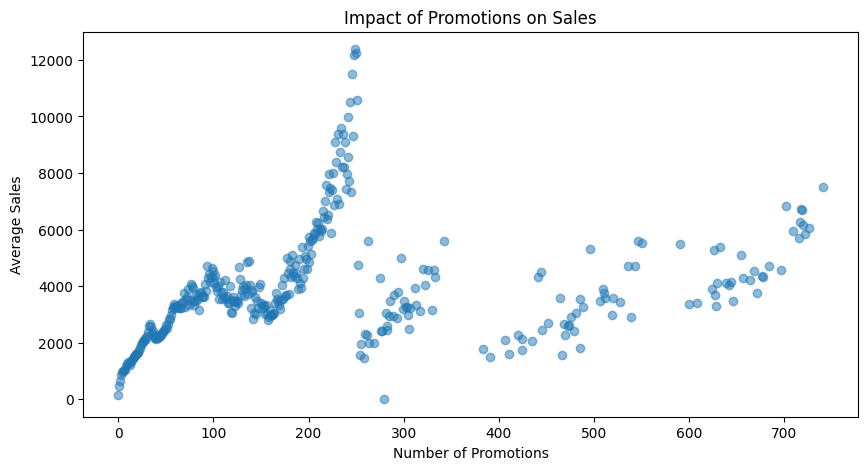

In [176]:
promo_sales = df.groupby('onpromotion')['sales'].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.scatter(promo_sales['onpromotion'], promo_sales['sales'], alpha=0.5)
plt.xlabel("Number of Promotions")
plt.ylabel("Average Sales")
plt.title("Impact of Promotions on Sales")
plt.show()

In [179]:
df.groupby(['family', 'onpromotion'])['sales'].mean().unstack().fillna(0)


onpromotion,0,1,2,3,4,5,6,7,8,9,...,702,710,716,717,718,719,720,722,726,741
family,,,,,,,,,,,,,,,,,,,,,
AUTOMOTIVE,5.865259,12.233641,13.734317,16.305755,19.480392,20.393443,22.304348,21.000000,20.714286,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BABY CARE,0.110766,1.636364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BEAUTY,3.082429,8.151597,9.505312,7.023973,9.296703,14.142857,18.250000,18.000000,60.500000,61.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BEVERAGES,1292.062514,2251.323224,2563.982088,2936.790470,3082.443172,3080.212594,3096.369994,3103.776635,3193.362442,3117.046900,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BOOKS,0.070701,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BREAD/BAKERY,379.777944,570.668725,618.569317,611.546945,507.241052,459.293849,580.358780,574.187727,547.580400,630.078293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CELEBRATION,7.995113,20.597343,16.299578,13.378378,13.472527,16.373737,22.022727,24.246575,29.614286,36.274510,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CLEANING,868.702172,1116.422190,1205.916338,1280.592839,1311.768870,1308.685928,1310.643258,1296.404858,1241.115789,1207.822245,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DAIRY,479.761710,798.734281,900.482100,975.833947,1013.468214,977.632989,919.119326,921.552898,951.326622,827.146370,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [180]:
df['isWeekend'] = df['date'].apply(lambda x: 1 if x.weekday() >= 5 else 0)

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,isHoliday,isWeekend
0,1782,2013-01-02,1,AUTOMOTIVE,2.000,0,93.14,Quito,Pichincha,0,0
1,1783,2013-01-02,1,BABY CARE,0.000,0,93.14,Quito,Pichincha,0,0
2,1784,2013-01-02,1,BEAUTY,2.000,0,93.14,Quito,Pichincha,0,0
3,1785,2013-01-02,1,BEVERAGES,1091.000,0,93.14,Quito,Pichincha,0,0
4,1786,2013-01-02,1,BOOKS,0.000,0,93.14,Quito,Pichincha,0,0
5,1787,2013-01-02,1,BREAD/BAKERY,470.652,0,93.14,Quito,Pichincha,0,0
6,1788,2013-01-02,1,CELEBRATION,0.000,0,93.14,Quito,Pichincha,0,0
7,1789,2013-01-02,1,CLEANING,1060.000,0,93.14,Quito,Pichincha,0,0
8,1790,2013-01-02,1,DAIRY,579.000,0,93.14,Quito,Pichincha,0,0
9,1791,2013-01-02,1,DELI,164.069,0,93.14,Quito,Pichincha,0,0


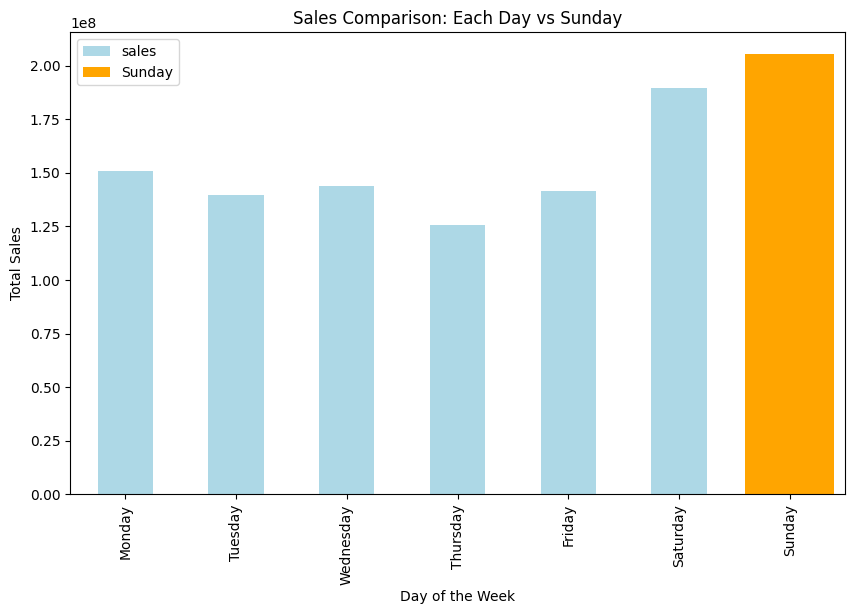

In [182]:
sales_by_weekday = df.groupby(df['date'].dt.weekday)['sales'].sum()

# Step 2: Plot a bar chart comparing each day to Sunday
plt.figure(figsize=(10, 6))
sales_by_weekday.plot(kind='bar', color='lightblue')

# Highlight Sunday for better comparison
plt.bar(6, sales_by_weekday.loc[6], color='orange', label='Sunday')

# Add titles and labels
plt.title('Sales Comparison: Each Day vs Sunday')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.legend()

# Show the plot
plt.show()

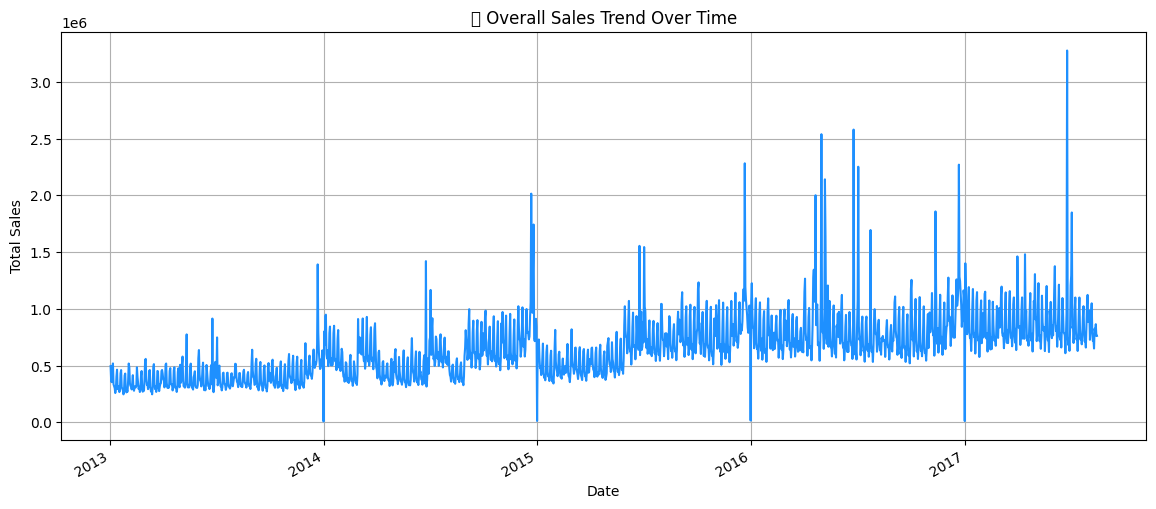

In [184]:
df['date'] = pd.to_datetime(df['date'])

#  Plot: Overall Sales Trend Over Time
plt.figure(figsize=(14, 6))
df.groupby('date').sum()['sales'].plot(title='📈 Overall Sales Trend Over Time', color='dodgerblue')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

Average sales on 15th and last day of the month: 362.49489028142847
Average sales on other days: 359.00341264630094


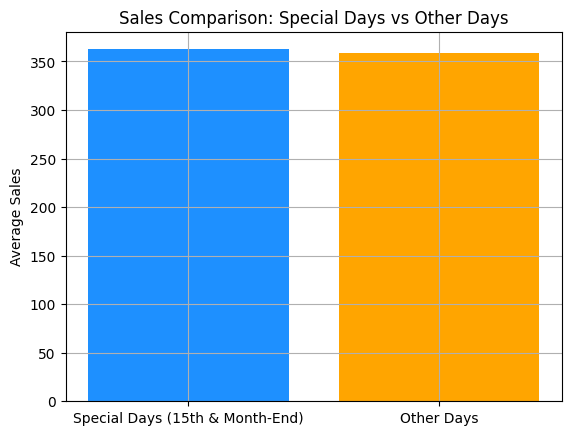

In [186]:
# Filter for 15th and last day of the month directly
special_days = df[(df['date'].dt.day == 15) | (df['date'].dt.is_month_end)]

# Filter for other days (excluding 15th and last day of the month)
other_days = df[~((df['date'].dt.day == 15) | (df['date'].dt.is_month_end))]

# Calculate average sales on special days vs other days
average_sales_special_days = special_days['sales'].mean()
average_sales_other_days = other_days['sales'].mean()

# Print the results
print(f"Average sales on 15th and last day of the month: {average_sales_special_days}")
print(f"Average sales on other days: {average_sales_other_days}")

# Visualize the comparison with a bar chart
sales_comparison = ['Special Days (15th & Month-End)', 'Other Days']
sales_values = [average_sales_special_days, average_sales_other_days]

plt.bar(sales_comparison, sales_values, color=['dodgerblue', 'orange'])
plt.title('Sales Comparison: Special Days vs Other Days')
plt.ylabel('Average Sales')
plt.grid(True)
plt.show()

In [191]:
special_days_mask = (df['date'].dt.day == 15) | (df['date'] == df['date'] + pd.offsets.MonthEnd(0))

# Filter special days and other days
special_days_sales = df[special_days_mask]['sales'].sum()
other_days_sales = df[~special_days_mask]['sales'].sum()

# Total sales
total_sales = df['sales'].sum()

# Calculate the ratio of special days sales to total sales
special_days_contribution = special_days_sales / total_sales

# Output the results
print(f"Sales on special days (15th and last day of the month): {special_days_sales}")
print(f"Sales on other days: {other_days_sales}")
print(f"Total sales: {total_sales}")
print(f"Contribution of special days sales to total sales: {special_days_contribution:.4f}")

# Optionally, you can calculate the average sales per special day vs. other days
average_special_days_sales = df[special_days_mask]['sales'].mean()
average_other_days_sales = df[~special_days_mask]['sales'].mean()

print(f"Average sales on special days: {average_special_days_sales:.2f}")
print(f"Average sales on other days: {average_other_days_sales:.2f}")

Sales on special days (15th and last day of the month): 71702214.28744711
Sales on other days: 1024870018.2998047
Total sales: 1096572232.5872505
Contribution of special days sales to total sales: 0.0654
Average sales on special days: 362.49
Average sales on other days: 359.00


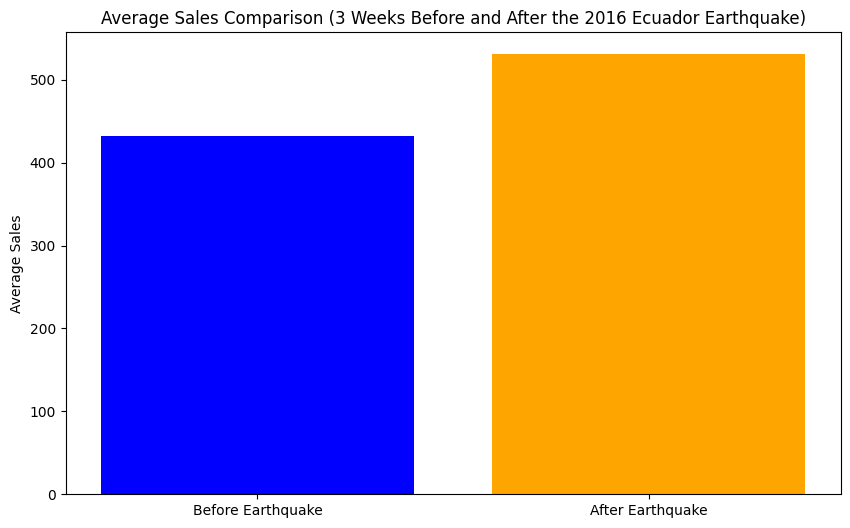

In [192]:
earthquake_date = pd.to_datetime('2016-04-16')
before_start = earthquake_date - pd.Timedelta(weeks=3)  # 3 weeks before
after_end = earthquake_date + pd.Timedelta(weeks=3)     # 3 weeks after

# Filter data for sales before and after the earthquake (3 weeks)
before_earthquake = df[(df['date'] >= before_start) & (df['date'] < earthquake_date)]
after_earthquake = df[(df['date'] >= earthquake_date) & (df['date'] <= after_end)]

# Calculate the average sales before and after the earthquake
avg_sales_before = before_earthquake['sales'].mean()
avg_sales_after = after_earthquake['sales'].mean()

# Plot the comparison between the two periods
plt.figure(figsize=(10, 6))
plt.bar(['Before Earthquake', 'After Earthquake'], [avg_sales_before, avg_sales_after], color=['blue', 'orange'])
plt.title('Average Sales Comparison (3 Weeks Before and After the 2016 Ecuador Earthquake)')
plt.ylabel('Average Sales')
plt.show()


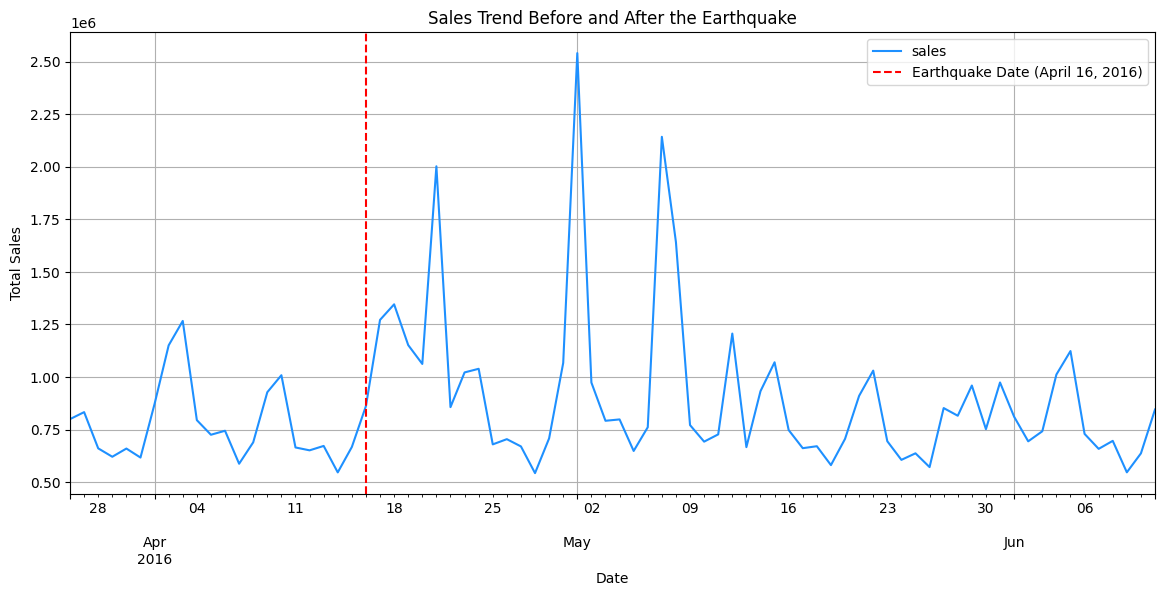

In [199]:
after_end2 = earthquake_date + pd.Timedelta(weeks=8) 
plt.figure(figsize=(14, 6))
df[df['date'].between(before_start, after_end2)].groupby('date').sum()['sales'].plot(title='Sales Trend Before and After the Earthquake', color='dodgerblue')
plt.axvline(x=earthquake_date, color='red', linestyle='--', label='Earthquake Date (April 16, 2016)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()

In [200]:
df['isWeekend'] = (df['date'].dt.weekday >= 5).astype(int)

In [201]:
df

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,isHoliday,isWeekend
0,1782,2013-01-02,1,AUTOMOTIVE,2.000,0,93.14,Quito,Pichincha,0,0
1,1783,2013-01-02,1,BABY CARE,0.000,0,93.14,Quito,Pichincha,0,0
2,1784,2013-01-02,1,BEAUTY,2.000,0,93.14,Quito,Pichincha,0,0
3,1785,2013-01-02,1,BEVERAGES,1091.000,0,93.14,Quito,Pichincha,0,0
4,1786,2013-01-02,1,BOOKS,0.000,0,93.14,Quito,Pichincha,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3052561,3000883,2017-08-15,9,POULTRY,438.133,0,47.57,Quito,Pichincha,0,0
3052562,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57,Quito,Pichincha,0,0
3052563,3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57,Quito,Pichincha,0,0
3052564,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57,Quito,Pichincha,0,0


In [202]:
backup2 = df

In [203]:
df = df.drop(columns=['city','state','id'])
df.head()

,date,store_nbr,family,sales,onpromotion,dcoilwtico,isHoliday,isWeekend
0,2013-01-02,1,AUTOMOTIVE,2.0,0,93.14,0,0
1,2013-01-02,1,BABY CARE,0.0,0,93.14,0,0
2,2013-01-02,1,BEAUTY,2.0,0,93.14,0,0
3,2013-01-02,1,BEVERAGES,1091.0,0,93.14,0,0
4,2013-01-02,1,BOOKS,0.0,0,93.14,0,0


In [208]:
le = LabelEncoder()
df['family'] = le.fit_transform(df['family'])
df.head()

,date,store_nbr,family,sales,onpromotion,dcoilwtico,isHoliday,isWeekend
0,2013-01-02,1,0,2.0,0,93.14,0,0
1,2013-01-02,1,1,0.0,0,93.14,0,0
2,2013-01-02,1,2,2.0,0,93.14,0,0
3,2013-01-02,1,3,1091.0,0,93.14,0,0
4,2013-01-02,1,4,0.0,0,93.14,0,0


In [210]:
df[df['date'] > '2016-08-15']

,date,store_nbr,family,sales,onpromotion,dcoilwtico,isHoliday,isWeekend
2393226,2016-08-16,1,0,5.000,0,46.57,0,0
2393227,2016-08-16,1,1,0.000,0,46.57,0,0
2393228,2016-08-16,1,2,5.000,0,46.57,0,0
2393229,2016-08-16,1,3,2010.000,23,46.57,0,0
2393230,2016-08-16,1,4,0.000,0,46.57,0,0
...,...,...,...,...,...,...,...,...
3052561,2017-08-15,9,28,438.133,0,47.57,0,0
3052562,2017-08-15,9,29,154.553,1,47.57,0,0
3052563,2017-08-15,9,30,2419.729,148,47.57,0,0
3052564,2017-08-15,9,31,121.000,8,47.57,0,0


In [211]:
split_date = '2016-08-15'

# Train set: Data before 2016-08-15
train_df = df[df['date'] < split_date]

# Validation set: Data from 2016-08-15 onwards
val_df = df[df['date'] >= split_date]

# Print the sizes
print(f"Train set size: {train_df.shape[0]}")
print(f"Validation set size: {val_df.shape[0]}")

Train set size: 2391444
Validation set size: 661122


In [212]:
x_train = train_df.drop(columns=['sales'])
y_train = train_df['sales']
x_val = val_df.drop(columns=['sales'])
y_val = val_df['sales']

In [217]:
x_train

,date,store_nbr,family,onpromotion,dcoilwtico,isHoliday,isWeekend
0,2013-01-02,1,0,0,93.1400,0,0
1,2013-01-02,1,1,0,93.1400,0,0
2,2013-01-02,1,2,0,93.1400,0,0
3,2013-01-02,1,3,0,93.1400,0,0
4,2013-01-02,1,4,0,93.1400,0,0
...,...,...,...,...,...,...,...
2391439,2016-08-14,9,28,0,43.1275,0,1
2391440,2016-08-14,9,29,1,43.1275,0,1
2391441,2016-08-14,9,30,1,43.1275,0,1
2391442,2016-08-14,9,31,5,43.1275,0,1


In [218]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df.drop(columns=['date'], inplace=True)
df.head()

,store_nbr,family,sales,onpromotion,dcoilwtico,isHoliday,isWeekend,year,month,day
0,1,0,2.0,0,93.14,0,0,2013,1,2
1,1,1,0.0,0,93.14,0,0,2013,1,2
2,1,2,2.0,0,93.14,0,0,2013,1,2
3,1,3,1091.0,0,93.14,0,0,2013,1,2
4,1,4,0.0,0,93.14,0,0,2013,1,2


In [219]:
x_train['year'] = x_train['date'].dt.year
x_train['month'] = x_train['date'].dt.month
x_train['day'] = x_train['date'].dt.day
x_train.drop(columns=['date'], inplace=True)
x_train.head()

,store_nbr,family,onpromotion,dcoilwtico,isHoliday,isWeekend,year,month,day
0,1,0,0,93.14,0,0,2013,1,2
1,1,1,0,93.14,0,0,2013,1,2
2,1,2,0,93.14,0,0,2013,1,2
3,1,3,0,93.14,0,0,2013,1,2
4,1,4,0,93.14,0,0,2013,1,2


In [220]:
x_val['year'] = x_val['date'].dt.year
x_val['month'] = x_val['date'].dt.month
x_val['day'] = x_val['date'].dt.day
x_val.drop(columns=['date'], inplace=True)
x_val.head()

,store_nbr,family,onpromotion,dcoilwtico,isHoliday,isWeekend,year,month,day
2391444,1,0,0,45.72,0,0,2016,8,15
2391445,1,1,0,45.72,0,0,2016,8,15
2391446,1,2,0,45.72,0,0,2016,8,15
2391447,1,3,37,45.72,0,0,2016,8,15
2391448,1,4,0,45.72,0,0,2016,8,15


In [222]:
param_grid = {
    'n_estimators': [300, 500, 1000],  
    'max_depth': [10, 20, 50, 100],  
    'min_samples_split': [2, 5, 8],  
    'min_samples_leaf': [1, 2, 4, 8],  
    'max_features': ['sqrt', 'log2', None], 
    'max_leaf_nodes': [None,10,20,70] 
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)


grid_search.fit(x_train, y_train)


print("Best Parameters found by GridSearchCV:")
print(grid_search.best_params_)

print("\nBest Cross-Validated Score (Negative MSE):")
print(grid_search.best_score_)


best_rf = grid_search.best_estimator_
print("\nBest RandomForestRegressor Parameter Values:")
for param, value in best_rf.get_params().items():
    print(f"{param}: {value}")


y_pred_val = best_rf.predict(x_val)
y_pred_train = best_rf.predict(x_train)

mae = mean_absolute_error(y_val, y_pred_val)
mae_train = mean_absolute_error(y_train, y_pred_train)
print(f"\nTest Set Mean Absolute Error (MAE): {mae:.2f}")
print(f"\nTest Set Mean Absolute Error (MAE): {mae_train:.2f}")

Fitting 3 folds for each of 1728 candidates, totalling 5184 fits


KeyboardInterrupt: 